In [1]:
import pandas as pd
import os
os.chdir(os.path.dirname(os.getcwd()))
import numpy as np
from datetime import datetime,date
from dateutil import relativedelta
import matplotlib.pyplot as plt
import copy
%load_ext autoreload
%autoreload 2
from src.data import preprocessing
import pickle as pkl

In [2]:
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
import itertools

In [3]:
from tbats import TBATS, BATS

# Forecasting the demand

In [4]:
path_demand_1 = '\\data\\raw\\ExitZoneAllocation.xlsx'
raw_demand_1 = os.getcwd() + path_demand_1

gas_demand_1 = pd.read_excel(raw_demand_1)

In [5]:
path_demand = '\\data\\raw\\Demand.xlsx'
raw_demand = os.getcwd() + path_demand

gas_demand = pd.read_excel(raw_demand)

In [6]:
gas_demand

,Name,Time,Data
0,Exit Zone - Flow kWh/h,01-01-2013,-4435664
1,Exit Zone - Flow kWh/h,02-01-2013,-5437593
2,Exit Zone - Flow kWh/h,03-01-2013,-5214496
3,Exit Zone - Flow kWh/h,04-01-2013,-5002616
4,Exit Zone - Flow kWh/h,05-01-2013,-4701222
...,...,...,...
2459,Exit Zone - Flow kWh/h,26-09-2019,-2296915
2460,Exit Zone - Flow kWh/h,27-09-2019,-2212404
2461,Exit Zone - Flow kWh/h,28-09-2019,-1595891
2462,Exit Zone - Flow kWh/h,29-09-2019,-1806336


In [7]:
gas_demand_1 = gas_demand_1.groupby(['Time'])['Data'].sum()


In [8]:
gas_demand_1.index = pd.to_datetime(gas_demand_1.index, format='%d-%m-%Y')

gas_demand_1.index = pd.DatetimeIndex(gas_demand_1.index.values, freq=gas_demand_1.index.inferred_freq)

# gas_demand_1['Data'] = gas_demand_1['Data']/1000

# gas_demand_1 = gas_demand_1[['Time','Data']]

In [9]:
gas_demand_1 = gas_demand_1.sort_index()

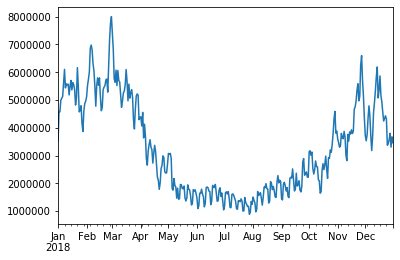

In [10]:
gas_demand_1.loc['2018'].plot()

In [12]:
gas_demand_1 = gas_demand_1/1000


In [13]:
gas_demand_1.head()

2012-01-01    3613.082
2012-01-02    4787.492
2012-01-03    5091.137
2012-01-04    5230.142
2012-01-05    5403.952
Name: Data, dtype: float64

In [14]:
gas_demand.index = gas_demand['Time']

gas_demand.index = pd.to_datetime(gas_demand.index, format='%d-%m-%Y')

gas_demand.index = pd.DatetimeIndex(gas_demand.index.values, freq=gas_demand.index.inferred_freq)
gas_demand['Time'] = gas_demand.index

gas_demand['Data'] = -gas_demand['Data']/1000

gas_demand = gas_demand[['Time','Data']]

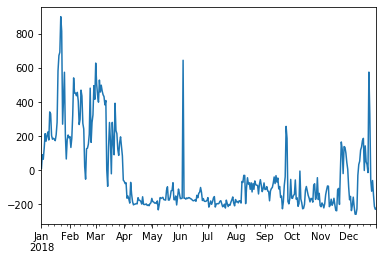

In [15]:
# Difference between flow and allocation
(gas_demand.loc['2018','Data'] - gas_demand_1.loc['2018']).plot()

In [16]:
if_TBATS = False

if if_TBATS:
    # Fit the model
    estimator = TBATS(seasonal_periods=(7, 365.25))
    model = estimator.fit(gas_demand.loc['2014':'2017','Data'])
    
    y_forecast = model.forecast(steps=365)
    
    model.summary()

In [17]:
if if_TBATS:
    plt.plot(y_forecast, markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
    plt.plot(gas_demand.loc['2018','Data'].values, color='olive', linewidth=2)

In [18]:
if if_TBATS:
    y_truth = gas_demand.loc['2018','Data'].values
    mse = ((y_forecast - y_truth) ** 2).mean()
    print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
    print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

## TSA

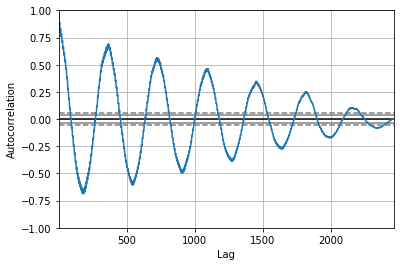

In [19]:
pd.plotting.autocorrelation_plot(gas_demand['Data'])

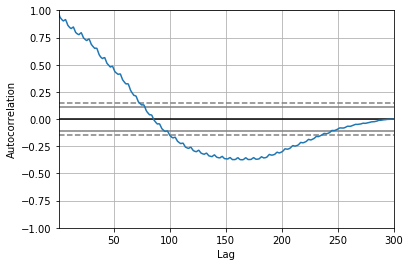

In [20]:
pd.plotting.autocorrelation_plot(gas_demand['Data'].iloc[:300])

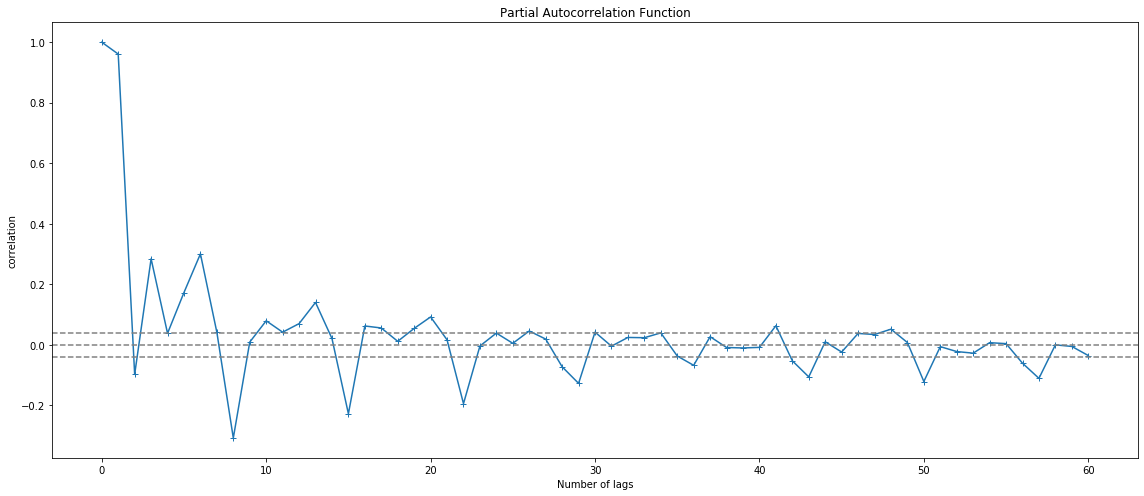

In [13]:
#calling partial correlation function
lag_pacf = pacf(gas_demand['Data'], nlags=60, method='ols')
#Plot PACF:
plt.figure(figsize=(16, 7))
plt.plot(lag_pacf,marker='+')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(gas_demand)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(gas_demand)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.xlabel('Number of lags')
plt.ylabel('correlation')
plt.tight_layout()

In [14]:
weekly_gas_demand = gas_demand.resample('W-Mon', on='Time')['Data'].sum()

In [15]:
weekly_gas_demand.loc['2013':'2018']

Time
2013-01-07    35586.490
2013-01-14    48278.801
2013-01-21    63516.794
2013-01-28    59216.911
2013-02-04    45605.009
                ...    
2018-12-03    32669.398
2018-12-10    27132.390
2018-12-17    39231.960
2018-12-24    33080.361
2018-12-31    23566.827
Freq: W-MON, Name: Data, Length: 313, dtype: float64

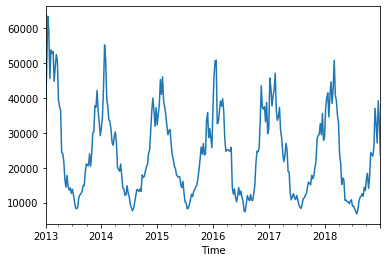

In [16]:
weekly_gas_demand.loc['2013':'2018'].plot()

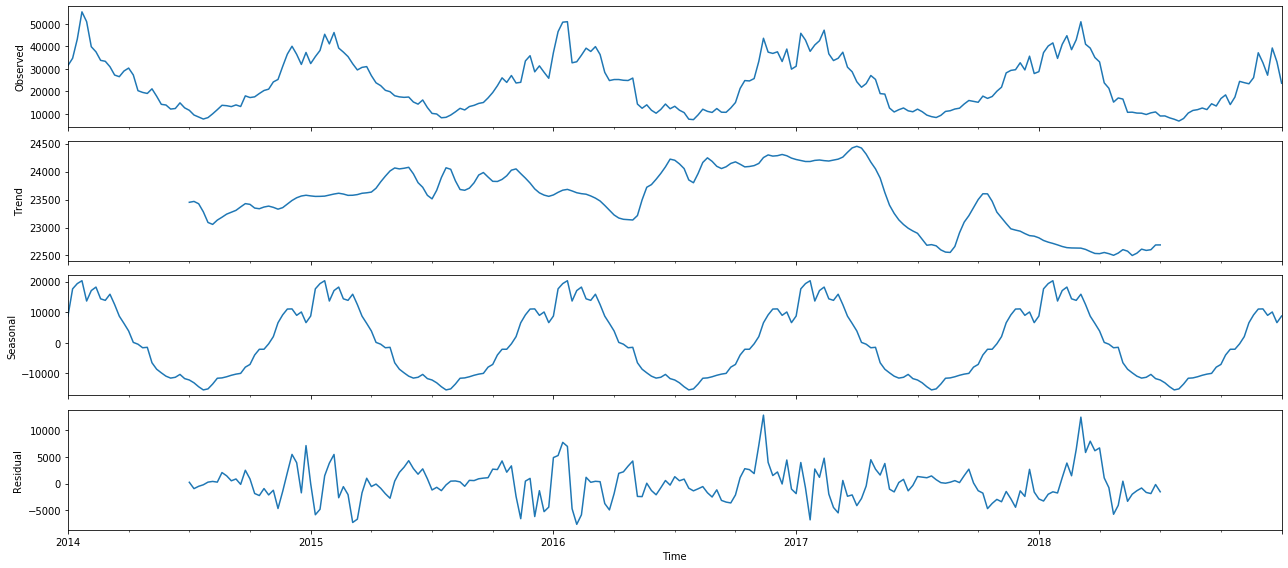

In [58]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition_yearly = sm.tsa.seasonal_decompose(weekly_gas_demand.loc['2014':'2018'], model='additive')
fig = decomposition_yearly.plot()
plt.show()

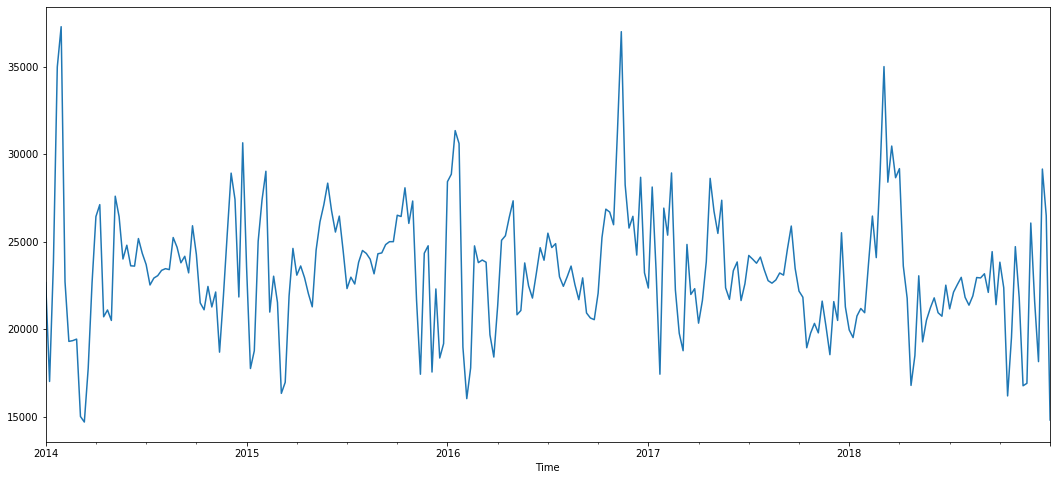

In [59]:
(decomposition_yearly.observed - decomposition_yearly.seasonal).plot()

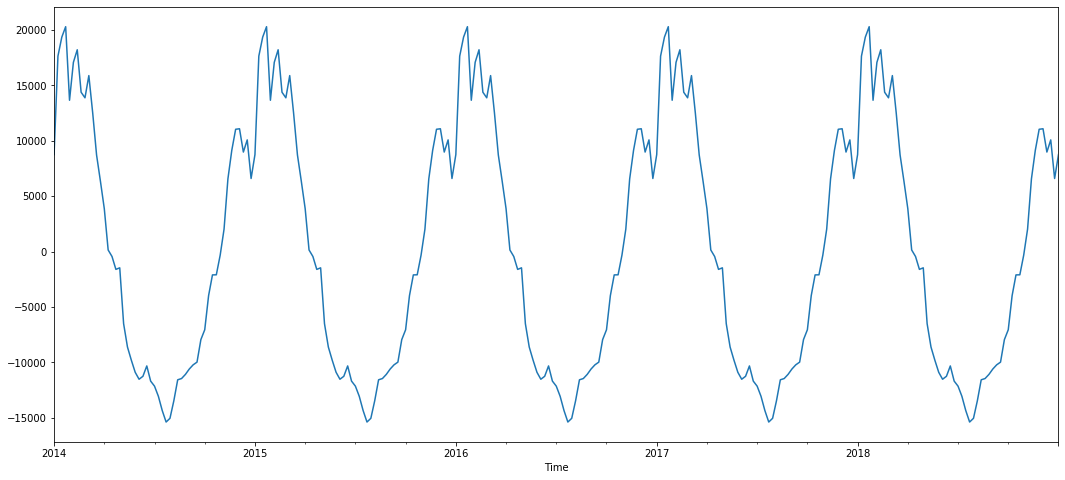

In [60]:
decomposition_yearly.seasonal.loc['2014':'2018'].plot()

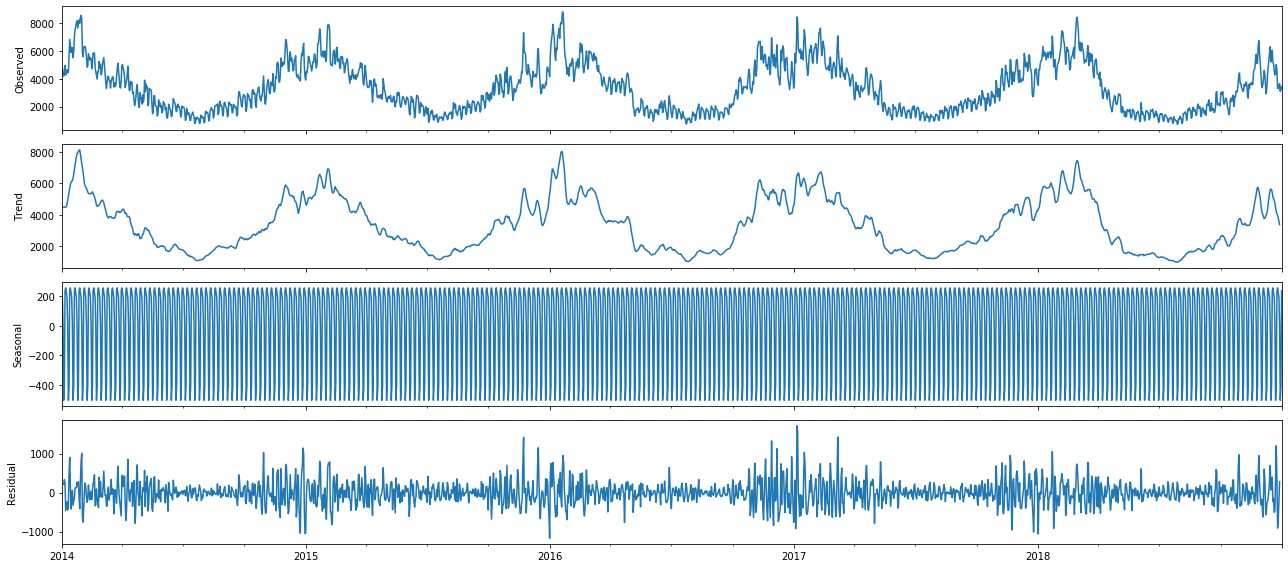

In [61]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition_weekly = sm.tsa.seasonal_decompose(gas_demand.loc['2014':'2018','Data'], model='additive')
fig = decomposition_weekly.plot()
plt.show()

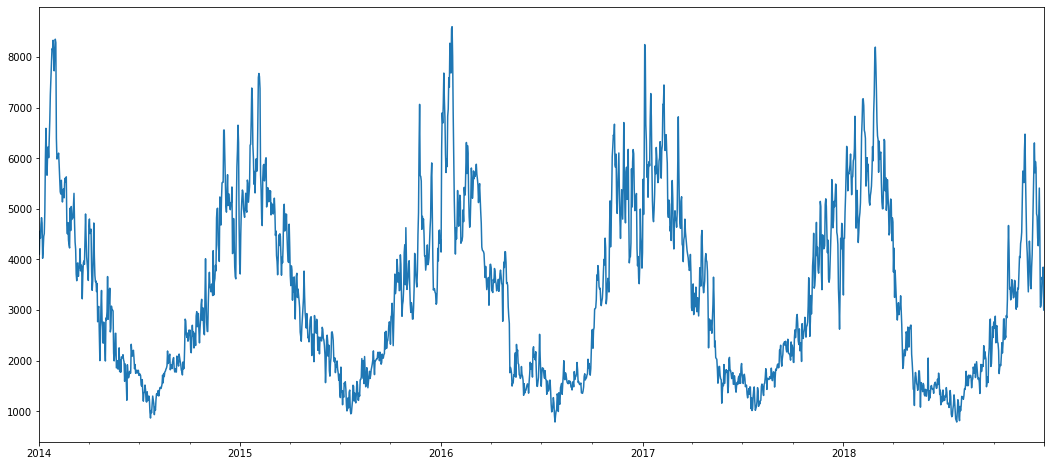

In [62]:
(decomposition_weekly.observed - decomposition_weekly.seasonal).plot()

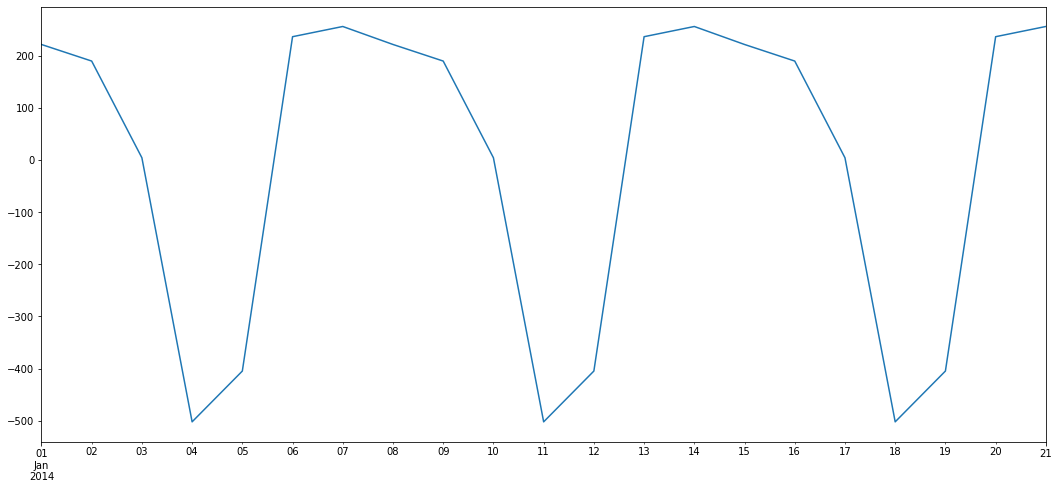

In [63]:
decomposition_weekly.seasonal.iloc[:21].plot()

In [64]:
decomposition_weekly.seasonal

2014-01-01    221.325669
2014-01-02    189.523302
2014-01-03      4.087215
2014-01-04   -502.177322
2014-01-05   -404.808284
                 ...    
2018-12-27    189.523302
2018-12-28      4.087215
2018-12-29   -502.177322
2018-12-30   -404.808284
2018-12-31    236.234880
Freq: D, Name: Data, Length: 1826, dtype: float64

In [65]:
decomposition_yearly.seasonal

Time
2014-01-06     8758.385337
2014-01-13    17651.215579
2014-01-20    19366.748031
2014-01-27    20311.443327
2014-02-03    13665.529632
                  ...     
2018-12-03    11090.654019
2018-12-10     8986.623755
2018-12-17    10084.044940
2018-12-24     6597.771325
2018-12-31     8758.385337
Freq: W-MON, Name: Data, Length: 261, dtype: float64

In [17]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]


In [18]:
grid_search_TSA = False

In [19]:
if grid_search_TSA:
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(weekly_gas_demand.loc['2014':'2018'],
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                results = mod.fit()
                print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue

ARIMA(0, 0, 0)x(0, 0, 0, 52) - AIC:6027.043812263173
ARIMA(0, 0, 0)x(0, 0, 1, 52) - AIC:4626.208141785632
ARIMA(0, 0, 0)x(0, 1, 0, 52) - AIC:4138.751046965279
ARIMA(0, 0, 0)x(0, 1, 1, 52) - AIC:3107.9192701108077
ARIMA(0, 0, 0)x(1, 0, 0, 52) - AIC:4157.156352374671
ARIMA(0, 0, 0)x(1, 0, 1, 52) - AIC:4136.92020270966
ARIMA(0, 0, 0)x(1, 1, 0, 52) - AIC:3112.4620897206487
ARIMA(0, 0, 0)x(1, 1, 1, 52) - AIC:3093.7717092334888
ARIMA(0, 0, 1)x(0, 0, 0, 52) - AIC:5815.7448220907045
ARIMA(0, 0, 1)x(0, 0, 1, 52) - AIC:4615.158742649477
ARIMA(0, 0, 1)x(0, 1, 0, 52) - AIC:4057.03481116916
ARIMA(0, 0, 1)x(0, 1, 1, 52) - AIC:3025.509006929588
ARIMA(0, 0, 1)x(1, 0, 0, 52) - AIC:4101.39302994527
ARIMA(0, 0, 1)x(1, 0, 1, 52) - AIC:4593.344914333633
ARIMA(0, 0, 1)x(1, 1, 0, 52) - AIC:3060.0889195934715
ARIMA(0, 0, 1)x(1, 1, 1, 52) - AIC:3019.2514627949067
ARIMA(0, 1, 0)x(0, 0, 0, 52) - AIC:5051.212186847776
ARIMA(0, 1, 0)x(0, 0, 1, 52) - AIC:4035.6771201188567
ARIMA(0, 1, 0)x(0, 1, 0, 52) - AIC:4111.75

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(0, 1, 1, 52) - AIC:6204.60740885244
ARIMA(0, 1, 0)x(1, 0, 0, 52) - AIC:4050.8639968611915
ARIMA(0, 1, 0)x(1, 0, 1, 52) - AIC:4027.473520077601
ARIMA(0, 1, 0)x(1, 1, 0, 52) - AIC:3078.727236188033


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(1, 1, 1, 52) - AIC:4630.741189177862
ARIMA(0, 1, 1)x(0, 0, 0, 52) - AIC:5030.038824603531
ARIMA(0, 1, 1)x(0, 0, 1, 52) - AIC:4018.404441721079
ARIMA(0, 1, 1)x(0, 1, 0, 52) - AIC:4087.240369560539


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(0, 1, 1, 52) - AIC:6190.164338082385
ARIMA(0, 1, 1)x(1, 0, 0, 52) - AIC:4050.751748492554
ARIMA(0, 1, 1)x(1, 0, 1, 52) - AIC:4005.5672202576316
ARIMA(0, 1, 1)x(1, 1, 0, 52) - AIC:3078.3004571018937


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(1, 1, 1, 52) - AIC:4855.739442086743
ARIMA(1, 0, 0)x(0, 0, 0, 52) - AIC:5070.341379579275
ARIMA(1, 0, 0)x(0, 0, 1, 52) - AIC:4054.021786141104
ARIMA(1, 0, 0)x(0, 1, 0, 52) - AIC:4075.5542099873273
ARIMA(1, 0, 0)x(0, 1, 1, 52) - AIC:3047.2401532195922
ARIMA(1, 0, 0)x(1, 0, 0, 52) - AIC:4050.057305017052
ARIMA(1, 0, 0)x(1, 0, 1, 52) - AIC:4041.712648099334
ARIMA(1, 0, 0)x(1, 1, 0, 52) - AIC:3041.491501111702
ARIMA(1, 0, 0)x(1, 1, 1, 52) - AIC:3043.267842935559
ARIMA(1, 0, 1)x(0, 0, 0, 52) - AIC:5052.338960782196
ARIMA(1, 0, 1)x(0, 0, 1, 52) - AIC:4036.634452130408
ARIMA(1, 0, 1)x(0, 1, 0, 52) - AIC:4052.709292993853
ARIMA(1, 0, 1)x(0, 1, 1, 52) - AIC:3020.030657872167
ARIMA(1, 0, 1)x(1, 0, 0, 52) - AIC:4050.1005444208777
ARIMA(1, 0, 1)x(1, 0, 1, 52) - AIC:4019.439919581223
ARIMA(1, 0, 1)x(1, 1, 0, 52) - AIC:3037.2566220147205
ARIMA(1, 0, 1)x(1, 1, 1, 52) - AIC:3016.102019394611
ARIMA(1, 1, 0)x(0, 0, 0, 52) - AIC:5052.699576768273
ARIMA(1, 1, 0)x(0, 0, 1, 52) - AIC:4037.19

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(0, 1, 1, 52) - AIC:4770.567662888698
ARIMA(1, 1, 0)x(1, 0, 0, 52) - AIC:4033.294681715362
ARIMA(1, 1, 0)x(1, 0, 1, 52) - AIC:4028.234476861556
ARIMA(1, 1, 0)x(1, 1, 0, 52) - AIC:3060.2927987091325


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(1, 1, 1, 52) - AIC:4727.586555770629
ARIMA(1, 1, 1)x(0, 0, 0, 52) - AIC:5030.882042874504
ARIMA(1, 1, 1)x(0, 0, 1, 52) - AIC:4017.406331399943
ARIMA(1, 1, 1)x(0, 1, 0, 52) - AIC:4055.8896889022785


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(0, 1, 1, 52) - AIC:3660.320881772883
ARIMA(1, 1, 1)x(1, 0, 0, 52) - AIC:4031.736868598966
ARIMA(1, 1, 1)x(1, 0, 1, 52) - AIC:4012.148009154213
ARIMA(1, 1, 1)x(1, 1, 0, 52) - AIC:3035.8388375173586


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(1, 1, 1, 52) - AIC:3579.495237163186


In [73]:
series = gas_demand.loc['2013':'2015','Data']

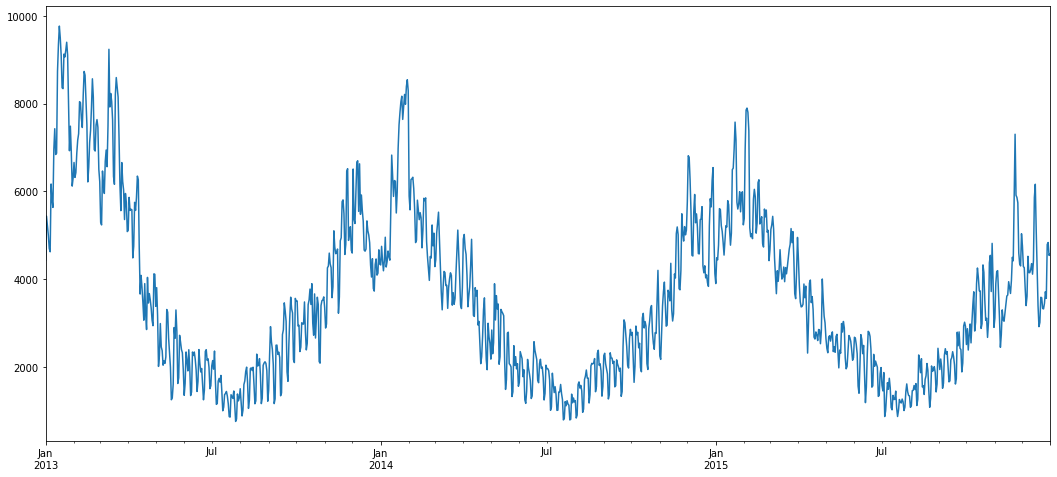

In [74]:
series.plot()

In [ ]:
# fit model
model = sm.tsa.statespace.SARIMAX(series,
                                  order=(7, 1, 7),
                                  seasonal_order=(1, 1, 0, 365),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
model_fit = model.fit(disp=0)
print(model_fit.summary())


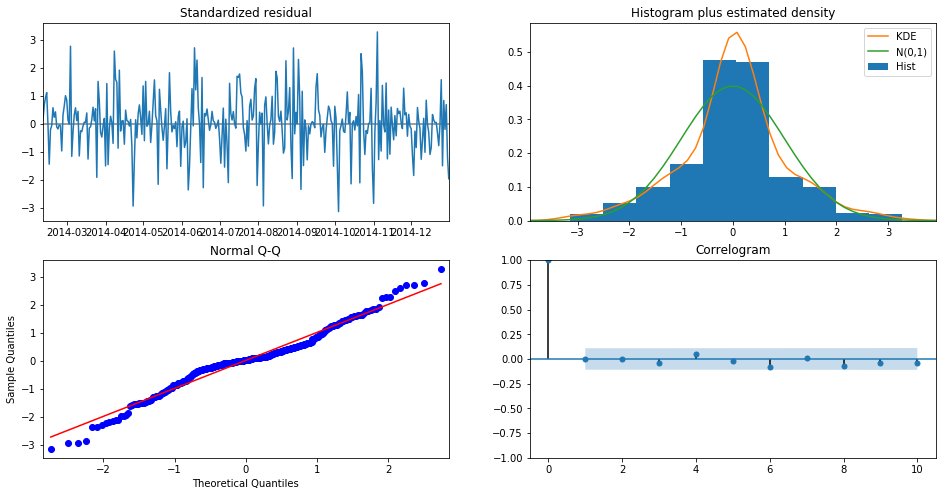

In [23]:
model_fit.plot_diagnostics(figsize=(16, 8))
plt.show()

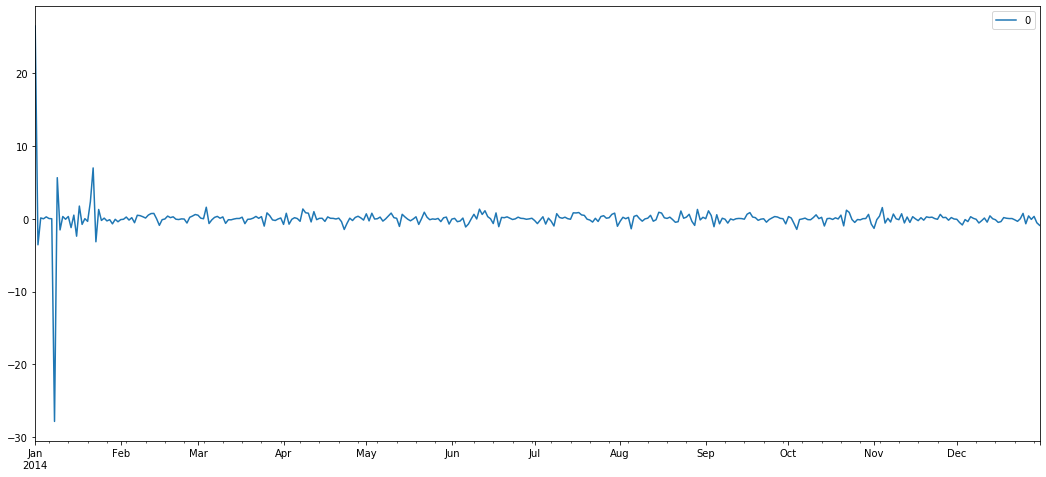

In [24]:
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()

                0
count  365.000000
mean     0.018496
std      2.146262
min    -27.836775
25%     -0.192603
50%      0.007395
75%      0.242021
max     26.440000


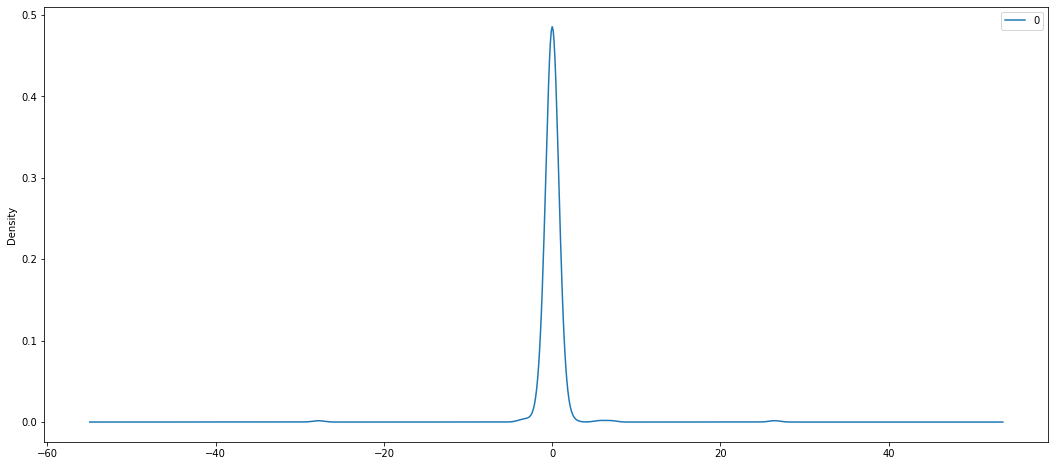

In [25]:
# density plot of the residual error values
residuals.plot(kind='kde')
print(residuals.describe())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


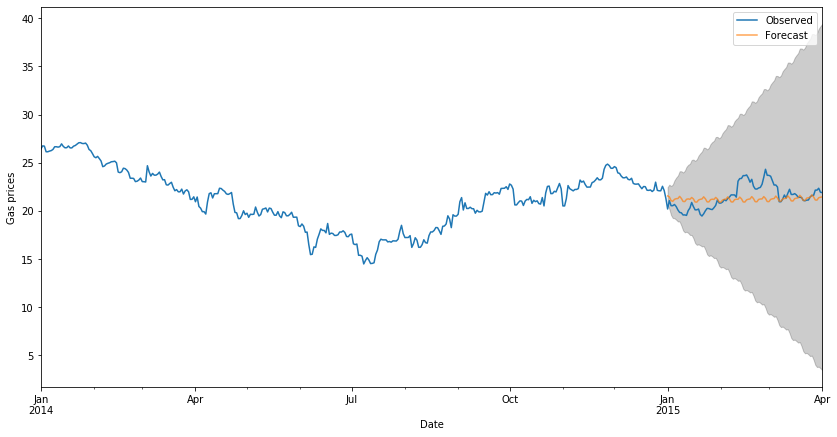

In [26]:
pred = model_fit.get_prediction(start=forecasting_since, end=forecasting_till, dynamic=False)
pred_ci = pred.conf_int()
ax = market_data[data_since:forecasting_till].plot(label='Observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Gas prices')
plt.legend()
plt.show()

In [27]:
y_forecasted = pred.predicted_mean
y_truth = market_data['2013-01-01':'2013-04-01']
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is nan
The Root Mean Squared Error of our forecasts is nan
